In [ ]:
!pip install scorecardpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from dateutil.parser import parse
from datetime import datetime
import scorecardpy as sc
df_train = pd.read_csv('/Users/amirzoyeva/Desktop/scoring/tr_for_students.csv')



df_train.head()

Для удобства сразу переведем столбец issue_d в тип dt.date и оставим только год и месяц, чтобы было удобнее агрегировать и анализировать

In [ ]:
df_train['issue_d'] = pd.to_datetime(df_train['issue_d']).dt.strftime('%Y-%m')

In [ ]:
df_train.describe()
#count - The number of not-empty values.
# mean - The average (mean) value.
# std - The standard deviation.
# min - the minimum value.
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

In [ ]:


# Посмотрим, в каких категориях есть пропуски до заполнения
missing_values_before = df_train.isna().sum()
print("Пропуски до заполнения:")
print(missing_values_before)

# Заполняем пропуски
#если не заполнены данные о работе, то заполним пропуск строкой "NAN" и создадим новый столбец, в котором укажем на каких позициях было осуществлено заполнение
df_train['emp_title_filled'] = np.where(df_train['emp_title'].isna(), 1, 0)

# Заполним ропуски в столбце 'emp_title' строкой "NAN"
df_train['emp_title'].fillna('NAN', inplace=True)

#заполним пропуски в столбце 'emp_length' средним значением стажа на работе
df_train['emp_length'].fillna(int(df_train['emp_length'].mean()), inplace=True)

# пропуски в столбце 'mths_since_recent_inq' заполним минус единицами (кажется, что многие люди могли не заполнить это поле, потому что не брали займы до этого, 
# а так мы сможем ограничить такие случаи от людей, которые пытались получить займ совсем недавно)
df_train['mths_since_recent_inq'].fillna(-1, inplace = True)
# со столбцом num_accts_ever_120_pd и num_tl_90g_dpd_24m та же ситуация: кажется, что люди могли не указать этот параметр, так как не имеют таких задолженностей

df_train['num_accts_ever_120_pd'].fillna(0, inplace = True)
df_train['num_tl_90g_dpd_24m'].fillna(0, inplace = True)
#столбец avg_cur_bal и tot_hi_cred_lim  заполним средним значением
meann= df_train['avg_cur_bal'].mean()
df_train['avg_cur_bal'].fillna(meann, inplace = True)
mean2 = df_train['tot_hi_cred_lim'].mean()
df_train['tot_hi_cred_lim'].fillna(mean2, inplace = True)
# cтолбец acc_open_past_24mths  в местах пропуска тоже заполним нулями
df_train['acc_open_past_24mths'].fillna(0, inplace = True)


In [ ]:
# Посмотрим, в каких категориях остались пропуски после заполнения
missing_values_after = df_train.isna().sum()
print("Пропуски после заполнения:")
print(missing_values_after)

In [ ]:
df_train.head()

Разделим признаки на категориальные и непрерывные:


In [ ]:
categorical = []
continuous = []
for i in df_train.columns:
    if ((df_train[i].dtype == int) or (df_train[i].dtype == float)):
        continuous.append(i)
    else:
        categorical.append(i)
  


In [ ]:
categorical

In [ ]:
continuous

In [ ]:


fig = go.Figure()

scatter_trace = go.Scatter(x=df_train['chargeoff_within_12_mths'], y=df_train['annual_inc'], mode='markers')

fig.add_trace(scatter_trace)

fig.update_layout(
    title='The relationship between annual income and the Number of charge-offs within 12 months',
    yaxis_title='Annual Income',
    xaxis_title='Number of charge-offs within 12 months'
)

fig.show()



Рассмотрим распределение непрерывных переменных

In [ ]:

updatemenu = [dict()]
buttons = []
data = []
fig_rasp = go.Figure()
for i in continuous:
    trace = px.histogram(df_train[i]).data[0]
    trace.visible = False
    data.append(trace) 
fig_rasp.add_traces(data) 
for i, col in enumerate(continuous):
    visibles = [False] * len(continuous)
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=[{"visible": visibles}]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig_rasp.update_layout(showlegend=True, updatemenus=updatemenu)
fig_rasp.update_layout(
    title={
        "text": "Distribution of continuous variables",
        "x": 0.5
    },
    xaxis_title="Range",
    yaxis_title="Number of values"
)
fig_rasp.show()

In [ ]:

fig_date = go.Figure()
fig_date.add_trace(px.histogram(df_train['issue_d']).data[0])
fig_date.update_layout(
    title={
        "text": "Number of observations per month ",
        "x": 0.5
    },
    xaxis_title="Month",
    yaxis_title="Number of observations"
)

In [ ]:
updatemenu = [dict()]
buttons = []
fig_cat= go.Figure()
data = []  

for i in categorical[1:]:
    trace = px.histogram(df_train[i]).data[0]
    trace.visible = False
    data.append(trace) 

fig_cat.add_traces(data) 
for i, col in enumerate(categorical[1:]):
    visibles = [False] * len(categorical[1:])
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=[{"visible": visibles}]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig_cat.update_layout(showlegend=True, updatemenus=updatemenu)
fig_cat.update_layout(
    title={
        "text": "Distribution of categorical variables",
        "x": 0.5
    },
    xaxis_title="Value",
    yaxis_title="Number of values"
)
fig_cat.show()

In [ ]:

df1 = df_train.groupby(['emp_length']).agg({'delinq_2yrs': 'sum'}).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df1, x='emp_length', y='delinq_2yrs')
plt.title('Number of late payments by number of years of work')
plt.xlabel('Work experience (years)')
plt.ylabel('Number of delays')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df2 = df_train.groupby('emp_length')['def'].value_counts()
df2 = df2.reset_index(name='count')
fig_def_emp = go.Figure()
fig_targ_rate = go.Figure()

dfD = df2[df2['def'] == 1]
dfN = df2[df2['def'] == 0]
df_rate = pd.merge(dfD, dfN, on =['emp_length'])

traceD = go.Bar(
    x=dfD['emp_length'],
    y=dfD['count'],
    name='Default',
    marker=dict(color="Blue"),
    text=dfD['count']
)
traceN = go.Bar(
    x=dfN['emp_length'],
    y=dfN['count'],
    name='Non-default',
    marker=dict(color="Red"),
    text=dfN['count']
)

data = [traceD, traceN]

fig_def_emp.add_traces(data)
    
fig_def_emp.update_layout(
    title={
        "text": "Number of default / nondefault loans by employment length",
        "x": 0.5
    },
    xaxis_title="Employment lengt",
    yaxis_title="Number of loans"

)
fig_def_emp.show()

df_rate['perc']= (df_rate['count_x']	/ df_rate['count_y'])*100
trace1 = go.Bar(
    x=df_rate['emp_length'],
    y=df_rate['perc'],
    name='Target rate',
    text=df_rate['perc']
)
fig_targ_rate.add_trace(trace1)
fig_targ_rate.update_layout(
    title={
        "text": "Target rate by employment length",
        "x": 0.5
    },
    xaxis_title="Employment lengt",
    yaxis_title="Target rate"

)
fig_targ_rate.show()


In [ ]:
df_rate

In [ ]:
df3 = df_train.groupby('home_ownership')['def'].value_counts()
df3 = df3.reset_index(name='count')
fig_def_home = go.Figure()
fig_targ_rate_2 = go.Figure()

dfD = df3[df3['def'] == 1]
dfN = df3[df3['def'] == 0]
df_rate_2 = pd.merge(dfD, dfN, on =['home_ownership'])
traceD = go.Bar(
    x=dfD['home_ownership'],
    y=dfD['count'],
    name='Default',
    marker=dict(color="Blue"),
    text=dfD['count']
)
traceN = go.Bar(
    x=dfN['home_ownership'],
    y=dfN['count'],
    name='Non-default',
    marker=dict(color="Red"),
    text=dfN['count']
)

data = [traceD, traceN]

fig_def_home.add_traces(data)
    
fig_def_home.update_layout(
    title={
        "text": "Number of default / nondefault loans by homeownership status",
        "x": 0.5
    },
    xaxis_title="Home ownership status",
    yaxis_title="Number of loans"

)
fig_def_home.show()

df_rate_2['perc']= (df_rate_2['count_x']	/ df_rate_2['count_y'])*100
trace2 = go.Bar(
    x=df_rate_2['home_ownership'],
    y=df_rate_2['perc'],
    name='Target rate',
    text=df_rate_2['perc']
)
fig_targ_rate_2.add_trace(trace2)
fig_targ_rate_2.update_layout(
    title={
        "text": "Target rate by home ownership status",
        "x": 0.5
    },
    xaxis_title="Home ownership status",
    yaxis_title="Target rate"

)
fig_targ_rate_2.show()


In [ ]:
import plotly.graph_objs as go

random_20 = df_train.sample(n=20, random_state=42)
sorted_rows = random_20.sort_values(by='annual_inc')

fig2 = go.Figure()


fig2.add_trace(go.Scatter(x=sorted_rows['annual_inc'], y=sorted_rows['installment'], mode='markers'))

fig2.update_layout(
    title='Relationship between annual income and monthly payment',
    xaxis_title='Annual Income',
    yaxis_title='Installment'
)

fig2.show()

Также необходимо посмотреть на корреляцию непрерывных переменных

In [ ]:
df_train.corr()

# Теперь попробуем сгенерировать некоторые новые признаки


In [ ]:
df_train

In [ ]:

continuous.remove('def')
continuous 


In [ ]:
df_without_cat = df_train.drop(categorical, axis = 1)
df_without_cat
df_without_cont = df_train.drop(continuous, axis = 1)
df_without_cont

Попробуем вернуться к зависимости между годовым доходом и месячным платежом, который полагается заемщику в случае выдачи займа. В новый признак запишем процент, который будет занимать месячный платеж от среднего месячного дохода 

In [ ]:
df_train['perc_month'] = (df_train['installment']/(df_train['annual_inc']/12))*100
continuous.append('perc_month')


Так же сгенерируем новые признаки на основе категориальных перменных:
нам неудобно работать с переменными, которые представлены строками, поэтому нам необходимо создать фиктивные переменные, такие что новые столбцы будут состоять из булевых переменных. Единицы будут стоять в тех строках, если соответствующее столбцу категориальная переменная принимает именно то значение, которое прописано в столбце:
Однако мы не будем делать такие переменные для всех категориальных признаков, например, переменные addr_state, purpose, sub_grade и emp_title принимают слишком много значений (посмотрим на графике распределения категориальных переменных), значит у нас будет слишком много столбцов, не несущих особого смысла. Также поступим и с issue_d.

Addr_state, purpose, sub_grade и emp_title мы преобразуем так: с помощью category_encoders построим биекцию из множества значений, принимаемых переменной в множество натуральных чисел

In [ ]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['issue_d','purpose', 'addr_state', 'sub_grade', 'emp_title'])
df_train = encoder.fit_transform(df_train)
df_train

In [ ]:
a = pd.get_dummies(df_train, columns = ['home_ownership'], drop_first=True)
df_train = a


In [ ]:

df_train

Теперь поделим наш датасет на тренировочную и валидационную выборку

In [ ]:
from sklearn.model_selection import train_test_split
target_train  = df_train['def']
df_train_lg = df_train.drop(['def'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(df_train_lg, target_train, test_size=0.2, random_state=42)


## Масштабирование  и обучение модели ##

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xtr_scaled = scaler.fit_transform(X_train)
Xval_scaled = scaler.transform(X_val)

Обучим модель

In [ ]:
from sklearn.linear_model import LogisticRegression
model =  LogisticRegression(random_state=0, penalty='l2')
model.fit(Xtr_scaled, y_train)



Теперь предскажем результаты

In [ ]:
y_pred = model.predict(Xval_scaled)


Теперь оценим наши результаты с помощью матрицы ошибок


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report

conf_m= confusion_matrix(y_val, y_pred)

cm_matrix = pd.DataFrame(data=conf_m)
sns.heatmap(cm_matrix, annot=True, fmt='d')


Основные показатели модели:

In [ ]:
print('accuracy_score= {:.3f}'.format(accuracy_score(y_val, y_pred)))
print('recall_score = {:.3f}'.format(recall_score(y_val, y_pred)))
print('precision_score = {:.3f}'.format(precision_score(y_val, y_pred)))

Далее оценим нашу модель с помощью показателя ROC-AUC:
Однако, для этого нам нужно получить вероятности принадлежности каждого заемщика (вектор признаков в нашем случае) к классу 0 ("нет дефолта") и 1 ("дефолт"). Для этого воспользуюсь функцией ```predict_proba```

In [ ]:
lr_probs = model.predict_proba(Xtr_scaled)
lr_probs_val = model.predict_proba(Xval_scaled)
lr_probs = lr_probs[:, 1]
lr_probs_val = lr_probs_val[:, 1]

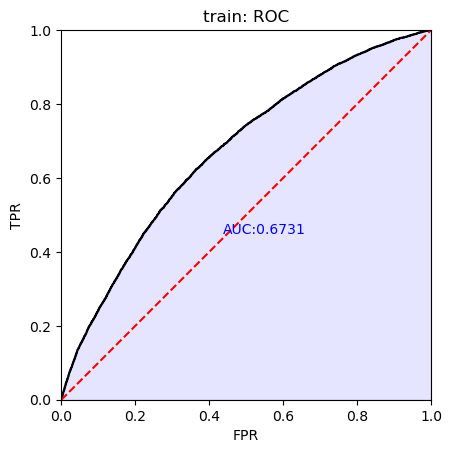

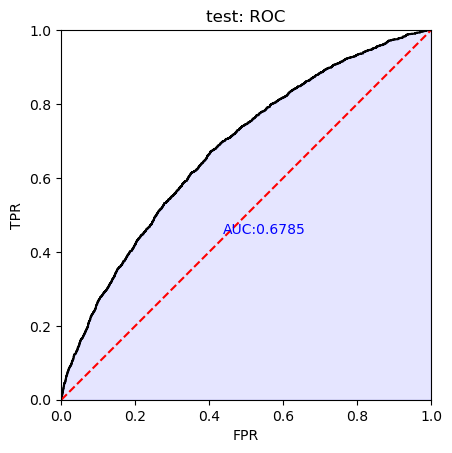

Gini coeff train  =  0.3462
Gini coeff test  = 0.3569


In [49]:

train_perf = sc.perf_eva(y_train,lr_probs ,plot_type = ["roc"], title = "train")
test_perf = sc.perf_eva(y_val,lr_probs_val ,plot_type = ["roc"], title = "test")
print('Gini coeff train  = ' , train_perf['Gini'])
print('Gini coeff test  =' , test_perf['Gini'])

Как видно, пока наша модель имеет показатель AUC = 0.67

# WOE преобразования


In [ ]:
bins = sc.woebin(df_train,
                 special_values={
        'home_ownership_NONE': [0,1],
        'home_ownership_OTHER': [0,1],
        'home_ownership_OWN': [0,1],
        'home_ownership_RENT': [0,1],
    }, y="def") 

In [ ]:
sc.woebin_plot(bins)


In [ ]:
information_values = sc.iv(df_train, y = "def" )
information_values


In [ ]:
filtered_iv = sc.var_filter(df_train, y = "def", iv_limit = 0.05)
filtered_iv.drop(['def'], axis=1, inplace = True)

Сравним, как изменился датасет после фильтрации

In [ ]:
df_train

In [ ]:
filtered_iv

Теперь обучим модель на отфильтрованных по information value признаках

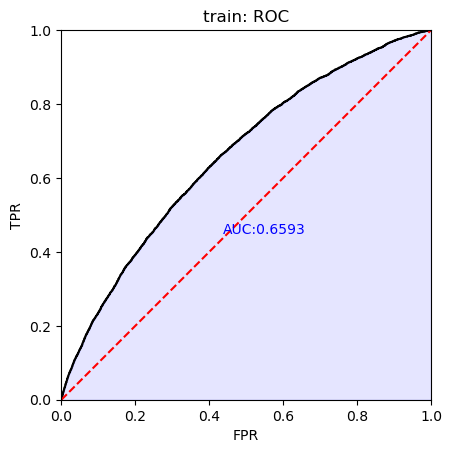

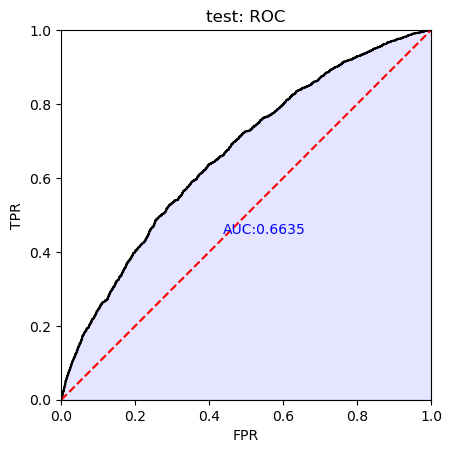

gini coeff train  =  0.3186
gini coeff test  = 0.3269


In [48]:
target_train_iv = df_train['def']
X_train_iv, X_val_iv, y_train_iv, y_val_iv = train_test_split(filtered_iv, target_train_iv, test_size=0.2, random_state=42)

scaler = StandardScaler()

Xtr_scaled_iv = scaler.fit_transform(X_train_iv)
Xval_scaled_iv = scaler.transform(X_val_iv)
model_iv =  LogisticRegression(random_state=0, penalty='l2')
model_iv.fit(Xtr_scaled_iv, y_train_iv)
y_pred_iv = model_iv.predict(Xval_scaled_iv)
lr_probs_iv = model_iv.predict_proba(Xtr_scaled_iv)
lr_probs_val_iv = model_iv.predict_proba(Xval_scaled_iv)
lr_probs_iv = lr_probs_iv[:, 1]
lr_probs_val_iv = lr_probs_val_iv[:, 1]
train_perf = sc.perf_eva(y_train_iv,lr_probs_iv ,plot_type = ["roc"], title = "train")
test_perf = sc.perf_eva(y_val_iv,lr_probs_val_iv ,plot_type = ["roc"], title = "test")
print('Gini coeff train  = ' , train_perf['Gini'])
print('Gini coeff test  =' , test_perf['Gini'])
